# **WARNING**

In order for this notebook to run, you must first run the notebook `2_0_generate_turn_data.ipynb` and generate the file `result/singlegame_results/player10_turn_results.csv` which contains the optimal policy and value functions for the solved MDPs for different player skill model and epsilon combinatinos. It is also important to make sure that all combinations you want to analyse in this file were generated during this process. 

# 1.0 Notebook Parameters

Please specify the following variables:
1. `project_directory`: your project directory path
2. `epsilon_list`: the list of execution error multiplers (epsilon) that you want to consider in your analysis.
3. `epsilon_list_extremes`: the list of *high* execution error multiplers (epsilon) that you want to consider in your analysis.
4. `epsilon_list_presentation`: the list of execution error multiplers (epsilon) used for a presentation comparison.
5. `player_id`: the players (i.e. skill model) you want to consider in your analysis; use one base model and scale it with different epsilons; this should match whatever was used in `1_0_generate_noturn_data.ipynb`.

In [10]:
# Change this to the project directory path for your computer  
project_directory = '/Users/rachael/Desktop/darts-thesis'
project_directory = '/Users/Craig/PycharmProjects/darts-thesis'
project_directory = '/Users/rachael/Desktop/test/darts-thesis'

# Set the epsilons that will be considered in this analysis 
epsilon_list = [1,2,3,4,5,6,7,8,9]

# These are the extreme epsilons used for the analysis of much weaker players 
epsilon_list_extremes = [25,50,100]

# These are the illustrative values showcased in research presentations 
epsilon_list_presentation = [1,9]

# Set the ID of the player skill models you want to use 
    # 10 - symmetric DB skill model that we were using up until now 
    # ? - "average pro" skill model generated by H & W 
player_id = 'AVG'

# 2.0 Notebook Setup

Import libraries and run prerequisites.

In [11]:
# Import and configure modules from this project

import os

os.chdir(project_directory)

import function_init_simple_mdp as imdp
import function_plot_board as ib
import function_init_board as fb

In [12]:
# Import and configure external modules

import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=300)
np.set_printoptions(threshold=300)

import pandas as pd

import numpy as np
import math
import scipy.io as sio
from scipy.stats import multivariate_normal

# Plotting 
import matplotlib.pyplot as plt

import seaborn as sns
#sns.set_theme()   # uncomment this if you want seasborn theme


In [13]:
# Helper functions for plotting


# KDE plot creator
def createKde(data, x, y, title="", ax=None, cmap='Blues', levels=10, alpha=1):
    if ax == None:
        ax = plt.gca()
    sns.kdeplot(data=data, x=x, y=y, cmap=cmap, fill=True, levels=levels, ax=ax, alpha=alpha)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ib.plot_basic_board(axes=ax)
    ax.title.set_text(title)


# Get player's gaussian distribution 
def get_gaussian(x_val,y_val,epsilon,player_index=7):
  
    result_dir = fb.data_parameter_dir + '/grid_full'
    if not os.path.isdir(result_dir):
        os.makedirs(result_dir)
    player_parameter = sio.loadmat('./data_parameter/ALL_Model_Fits.mat')
    avg_model_t20 = sio.loadmat('./data_parameter/AVG_Model_Fits/ModelFit_T20_fixmu.mat')
    avg_model_t19 = sio.loadmat('./data_parameter/AVG_Model_Fits/ModelFit_T19_fixmu.mat')
    avg_model_t18 = sio.loadmat('./data_parameter/AVG_Model_Fits/ModelFit_T18_fixmu.mat')
    avg_model_t17 = sio.loadmat('./data_parameter/AVG_Model_Fits/ModelFit_T17_fixmu.mat')
    avg_model_b50 = sio.loadmat('./data_parameter/AVG_Model_Fits/ModelFit_B50_fixmu.mat')
    avg_model_AllDoubles = sio.loadmat('./data_parameter/AVG_Model_Fits/ModelFit_AllDoubles_fixmu.mat')
    
    
    ## 1mm-width grid of 341*341 aiming locations (a sqaure enclosing the circle dart board)
    [xindex, yindex, xgrid, ygrid, grid_num] = fb.get_1mm_grid()

    xi = np.where(xgrid==x_val)[0][0]
    yi = np.where(xgrid==y_val)[0][0]

    ## select the proper Gaussian distribution according to the area to which the aiming location belongs
    if player_index == 'AVG':

        ## select the proper Gaussian distribution according to the area to which the aiming location belongs
        mu = [xgrid[xi], ygrid[yi]]
        score, multiplier = fb.get_score_and_multiplier(mu)
        if (score==60 and multiplier==3): ##triple 20
            covariance_matrix = avg_model_t20['ModelFit_T20_fixmu'][0][0][2] * epsilon
        elif (score==57 and multiplier==3): ##triple 19
            covariance_matrix = avg_model_t19['ModelFit_T19_fixmu'][0][0][2] * epsilon
        elif (score==54 and multiplier==3): ##triple 18
            ccovariance_matrix = avg_model_t18['ModelFit_T18_fixmu'][0][0][2] * epsilon 
        elif (score==51 and multiplier==3): ##triple 17
            covariance_matrix = avg_model_t17['ModelFit_T17_fixmu'][0][0][2] * epsilon 
        elif (score==50 and multiplier==2): ##double bull
            covariance_matrix = avg_model_b50['ModelFit_B50_fixmu'][0][0][2] * epsilon 
        else:
            covariance_matrix = avg_model_AllDoubles['ModelFit_AllDoubles_fixmu'][0][0][2] * epsilon 
                    
    else: 

        mu = [xgrid[xi], ygrid[yi]]
        score, multiplier = fb.get_score_and_multiplier(mu)
        if (score==60 and multiplier==3): ##triple 20
            covariance_matrix = player_parameter['ModelFit_T20'][0, player_index][2] * epsilon
        elif (score==57 and multiplier==3): ##triple 19
            covariance_matrix = player_parameter['ModelFit_T19'][0, player_index][2] * epsilon
        elif (score==54 and multiplier==3): ##triple 18
            covariance_matrix = player_parameter['ModelFit_T18'][0, player_index][2] * epsilon
        elif (score==51 and multiplier==3): ##triple 17
            covariance_matrix = player_parameter['ModelFit_T17'][0, player_index][2] * epsilon
        elif (score==50 and multiplier==2): ##double bull
            covariance_matrix = player_parameter['ModelFit_B50'][0, player_index][2] * epsilon
        else:
            covariance_matrix = player_parameter['ModelFit_All_Doubles'][0, player_index][2] * epsilon
                
    return mu,covariance_matrix


# Plot gaussian dsitribution 
def plot_gaussian(x_val,y_val,error_multiplier,player_index=7,xlim=(-200,200),ylim=(-200,200),figsize = (8,8),ax=None,title=''):
  
  mu,covariance_matrix = get_gaussian(x_val,y_val,error_multiplier,player_index=player_index)
  rv = multivariate_normal(mu, covariance_matrix)
  
  x, y = np.mgrid[-200:200:1, -200:200:1]
  pos = np.dstack((x, y))
  
  axes = ib.plot_basic_board(xlim=xlim,ylim=ylim,figsize = figsize,axes=ax)
  #axes.plot(x_val, y_val, "or")

  ax.title.set_text(title)
  
  fi = axes.contourf(x, y, rv.pdf(pos), 20, cmap='Greens')


# 3.0 Load Data

In [16]:
# Load data
df = pd.read_csv(f'result/singlegame_results/player{player_id}_turn_results.csv')
df = df.loc[df.player==player_id]

# Read only the relevant columns - note that this will result in duplicates if you include multiple players 
df = df[['epsilon','tokens','score','remaining_throws','score_gained','optimal_value','optimal_policy']]

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

# Add boolean column to indicate whether the policy uses tokens or not 
df['policy_is_token'] = df['optimal_policy'] >= imdp.throw_num

# Add a column to keep track of the score minus score gained in turn
df['score_in_turn'] = df['score'] - df['score_gained']


In [18]:
# Get dataframe with no tokens
df0 = df.loc[df.tokens==0].copy()

# Create dataframes for each individual epsilon in main list
epsilon_dfs = []

for epsilon in epsilon_list:
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_policy_name'].copy()
    epsilon_dfs.append(temp)

# Create dataframes for each of the extreme epsilons
epsilon_dfs_extremes = []

for epsilon in epsilon_list_extremes:
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_policy_name'].copy()
    epsilon_dfs_extremes.append(temp)

# Create dataframes for each of the presentation epsilons
epsilon_dfs_presentation = []

for epsilon in epsilon_list_presentation:
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_policy_name'].copy()
    epsilon_dfs_presentation.append(temp)


In [31]:
# [For normal epsilon] expand the above dataframes to include the coordinates of each action 
epsilon_dfs_expanded = []

for e in range(len(epsilon_list)):

    epsilon = epsilon_list[e]

    temp_list = []
    for action in epsilon_dfs[e]: 
        try: 
            temp_list.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
        except: 
            continue

    temp = pd.DataFrame(temp_list, columns = ['a','x','y'])
    
    epsilon_dfs_expanded.append(temp)

# [For extreme epsilon] expand the above dataframes to include the coordinates of each action 
epsilon_dfs_expanded_extremes = []

for e in range(len(epsilon_list_extremes)):

    epsilon = epsilon_list_extremes[e]

    temp_list = []
    for action in epsilon_dfs_extremes[e]: 
        try: 
            temp_list.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
        except: 
            continue

    temp = pd.DataFrame(temp_list, columns = ['a','x','y'])
    
    epsilon_dfs_expanded_extremes.append(temp)

# [For presentation epsilon] expand the above dataframes to include the coordinates of each action 
epsilon_dfs_expanded_presentation = []

for e in range(len(epsilon_list_presentation)):

    epsilon = epsilon_list_presentation[e]

    temp_list = []
    for action in epsilon_dfs_presentation[e]: 
        try: 
            temp_list.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
        except: 
            continue

    temp = pd.DataFrame(temp_list, columns = ['a','x','y'])
    
    epsilon_dfs_expanded_presentation.append(temp)

# 4.0 Policy Heatmaps

### 4.1 Heatmaps for Normal Epsilon

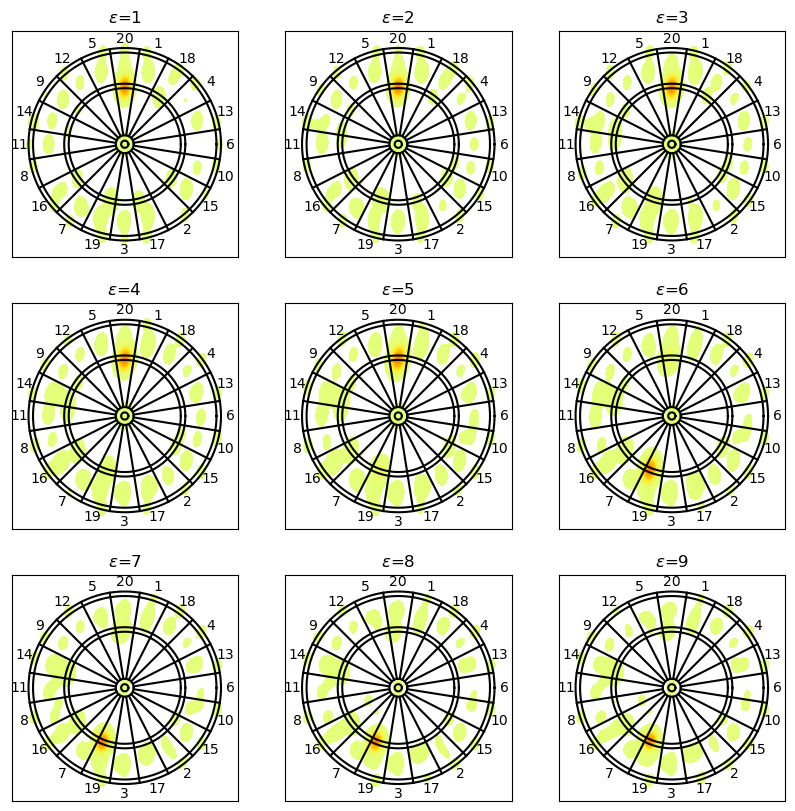

In [20]:
# Color parameters
cmap = 'Wistia'
alpha = 1
levels = 50

# Figure size
fig, ax = plt.subplots(3, 3,figsize=(10,10))

# Plot KDEs 
for e in range(len(epsilon_dfs_expanded)):

    row = math.floor(e/3)
    col = e%3 

    createKde(data=epsilon_dfs_expanded[e], x='x', y='y', title=f"$\epsilon$={epsilon_list[e]}", ax=ax[row,col], cmap=cmap, levels=levels, alpha=alpha)



### 4.2 Heatmaps for High Epsilon

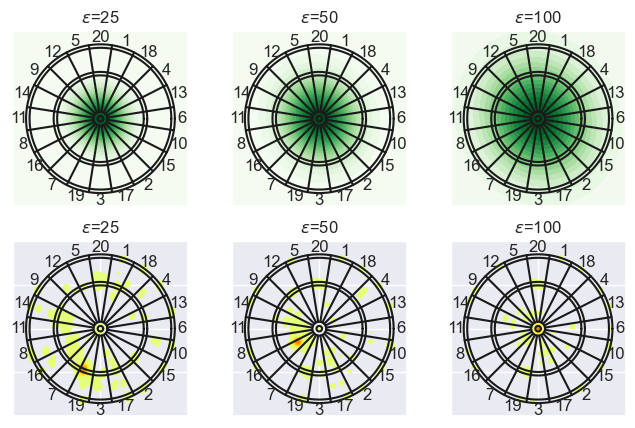

In [21]:
# Color parameters
cmap = 'Wistia'
levels = 30
sns.set_theme()

# Gaissoam Centroid 
x_val=0
y_val=0

# Figure size
fig, ax = plt.subplots(2, 3, figsize=(8,5))

# Plot KDEs
for e in range(len(epsilon_list_extremes)):
    col = e % 3
    plot_gaussian(x_val,y_val,epsilon_list_extremes[e],player_index="AVG",xlim=(-200,200),ylim=(-200,200),ax=ax[0,col],title='$\epsilon$={}'.format(epsilon_list_extremes[e]))
    createKde(data=epsilon_dfs_expanded_extremes[e], x='x', y='y', title="$\epsilon$={}".format(epsilon_list_extremes[e]), ax=ax[1,col], cmap=cmap, levels=levels, alpha=alpha)

    #plt.tight_layout()

### 4.3 Heatmaps for Presentation Epsilon

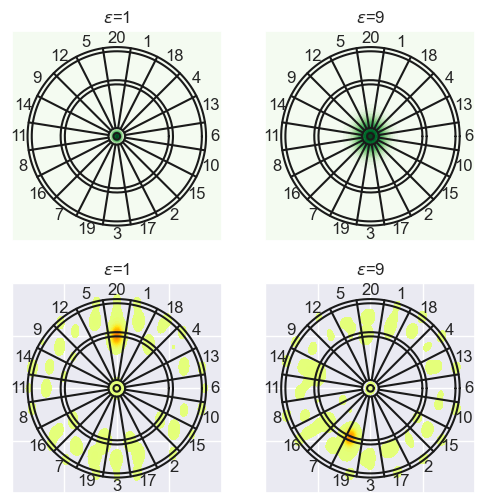

In [22]:
cmap = 'Wistia'
alpha = 1
levels = 30 #50

x_val=0
y_val=0

fig, ax = plt.subplots(2, 2, figsize=(6,6))

for e in range(len(epsilon_list_presentation)):
    col = e % 3
    plot_gaussian(x_val,y_val,epsilon_list_presentation[e],player_index=10,xlim=(-200,200),ylim=(-200,200),ax=ax[0,col],title='$\epsilon$={}'.format(epsilon_list_presentation[e]))
    createKde(data=epsilon_dfs_expanded_presentation[e], x='x', y='y', title="$\epsilon$={}".format(epsilon_list_presentation[e]), ax=ax[1,col], cmap=cmap, levels=levels, alpha=alpha)

    #plt.tight_layout()

## 5.0 Policy Token Usage

In [23]:

token_dfs = []

for epsilon in range(7):
    
    temp = df.loc[df.epsilon==epsilon].set_index('epsilon')['optimal_value'].copy()
    token_dfs.append(temp)


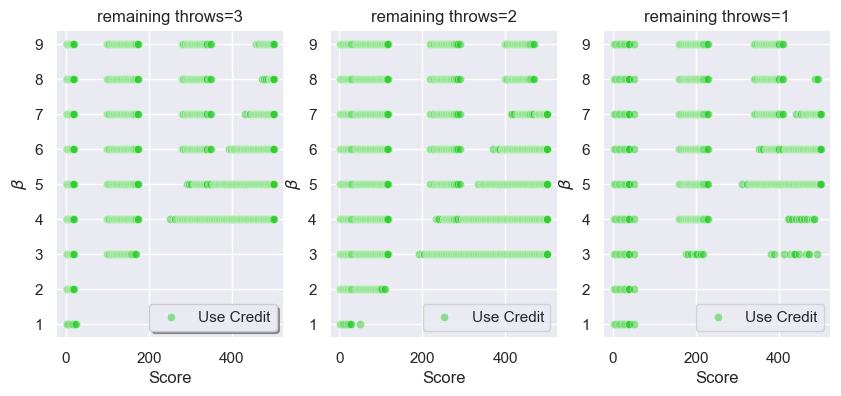

In [24]:
figure, ax = plt.subplots(1, 3,figsize=(10,4))

epsilon = 1
df_temp = df[df.optimal_policy != -1]
df_temp = df_temp[df_temp.score_gained == 0]
df_temp3 = df_temp[df_temp.remaining_throws==3]
df_actions3 = df_temp3[df_temp3.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[0])
#fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[0])

fig = ax[0].set_ylabel(r'$\beta$')
fig = ax[0].set_xlabel(r'Score')
fig = ax[0].set_title(rf'remaining throws={3}')
fig = ax[0].legend(loc='lower right', fancybox=True, shadow=True)

# max_token_list = []
# min_throw_list = []
# for t in range(10):
#     max_token = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==True)].score.max()
#     min_throw = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==False)].score.min()
#     # ax[0].plot(max_token,t,marker='X',markersize=10,color='green')
#     ax[0].plot(min_throw,t,marker='P',markersize=10,color='blue')


df_temp2 = df_temp[df_temp.remaining_throws==2]
df_actions2 = df_temp2[df_temp2.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[1])
#fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[1])

fig = ax[1].set_ylabel(r'$\beta$')
fig = ax[1].set_xlabel(r'Score')
fig = ax[1].set_title(rf'remaining throws={2}')
#fig = ax[1].legend(loc='lower right', fancybox=True, shadow=True)

# max_token_list = []
# min_throw_list = []
# for t in range(10):
#     max_token = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==True)].score.max()
#     min_throw = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==False)].score.min()
#     #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
#     ax[1].plot(min_throw,t,marker='P',markersize=10,color='blue')


df_temp1 = df_temp[df_temp.remaining_throws==1]
df_actions1 = df_temp1[df_temp1.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[2])
#fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[2])

fig = ax[2].set_ylabel(r'$\beta$')
fig = ax[2].set_xlabel(r'Score')
fig = ax[2].set_title(rf'remaining throws={1}')
#fig = ax[2].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
# for t in range(10):
#     max_token = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==True)].score.max()
#     min_throw = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==False)].score.min()
#     #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
#     ax[2].plot(min_throw,t,marker='P',markersize=10,color='blue')


#fig = figure.suptitle(r'Optimal Use of Credits in Different States')



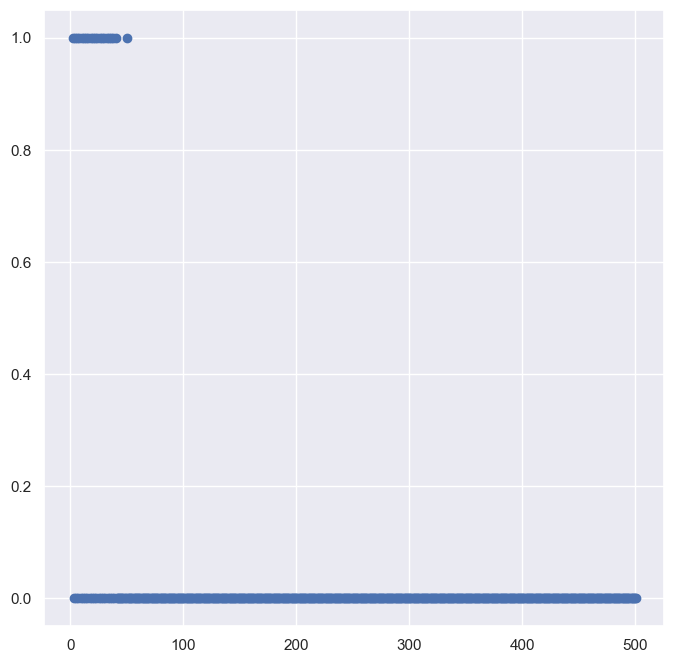

In [25]:
temp = df.groupby(['epsilon','tokens','score_in_turn']).policy_is_token.sum() / df.groupby(['epsilon','tokens','score_in_turn']).policy_is_token.count()
temp = temp.reset_index()
temp = temp.loc[temp.epsilon==5]
temp = temp.loc[temp.tokens==1]
temp
plt.scatter(x=temp['score_in_turn'],y=temp['policy_is_token'])
#temp.plot()


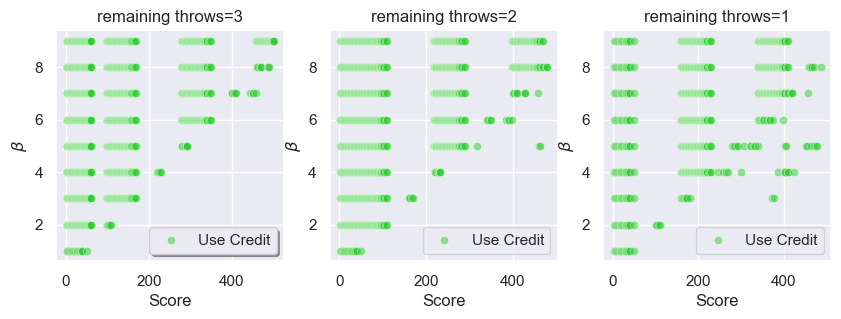

In [26]:
figure, ax = plt.subplots(1, 3,figsize=(10,3))

epsilon = 100
df_temp = df[df.optimal_policy != -1]
df_temp = df[df.score_gained == 0]
df_temp3 = df_temp[df_temp.remaining_throws==3]
df_actions3 = df_temp3[df_temp3.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[0])
#fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[0])

fig = ax[0].set_ylabel(r'$\beta$')
fig = ax[0].set_xlabel(r'Score')
fig = ax[0].set_title(rf'remaining throws={3}')
fig = ax[0].legend(loc='lower right', fancybox=True, shadow=True)

# max_token_list = []
# min_throw_list = []
# for t in range(10):
#     max_token = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==True)].score.max()
#     min_throw = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==False)].score.min()
#     # ax[0].plot(max_token,t,marker='X',markersize=10,color='green')
#     ax[0].plot(min_throw,t,marker='P',markersize=6,color='blue')


df_temp2 = df_temp[df_temp.remaining_throws==2]
df_actions2 = df_temp2[df_temp2.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[1])
#fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[1])

fig = ax[1].set_ylabel(r'$\beta$')
fig = ax[1].set_xlabel(r'Score')
fig = ax[1].set_title(rf'remaining throws={2}')
#fig = ax[1].legend(loc='lower right', fancybox=True, shadow=True)

# max_token_list = []
# min_throw_list = []
# for t in range(10):
#     max_token = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==True)].score.max()
#     min_throw = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==False)].score.min()
#     #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
#     ax[1].plot(min_throw,t,marker='P',markersize=6,color='blue')


df_temp1 = df_temp[df_temp.remaining_throws==1]
df_actions1 = df_temp1[df_temp1.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[2])
#fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[2])

fig = ax[2].set_ylabel(r'$\beta$')
fig = ax[2].set_xlabel(r'Score')
fig = ax[2].set_title(rf'remaining throws={1}')
#fig = ax[2].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==True)].score.max()
    min_throw = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==False)].score.min()
    #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
    #ax[2].plot(min_throw,t,marker='P',markersize=6,color='blue')


#fig = figure.suptitle(r'Optimal Use of Credits in Different States')



<AxesSubplot: xlabel='score_in_turn', ylabel='score_gained'>

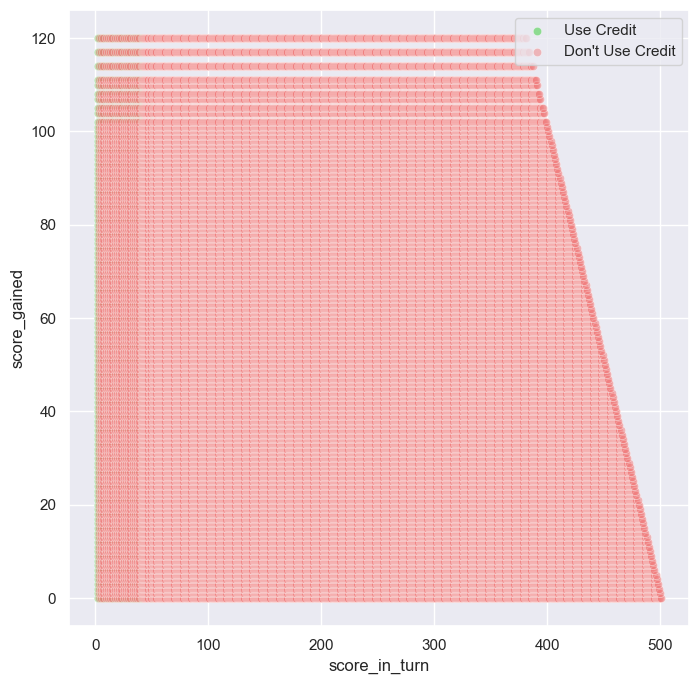

In [27]:
tokens = 1 
epsilon = 1
i = 1 

df_policy_check = df.loc[(df.tokens==tokens) & (df.epsilon==epsilon) & (df.remaining_throws==i)]
df_policy_check[['score_gained','score_in_turn','policy_is_token']]

sns.scatterplot(data=df_policy_check.loc[df_policy_check.policy_is_token==True], x="score_in_turn",y="score_gained",alpha=0.5,label='Use Credit',color='limegreen')
sns.scatterplot(data=df_policy_check.loc[df_policy_check.policy_is_token==False], x="score_in_turn",y="score_gained",alpha=0.5,label='Don\'t Use Credit',color='lightcoral')

#fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[2])

Text(0.5, 0.01, 'Score In Turn ($\\theta - u$)')

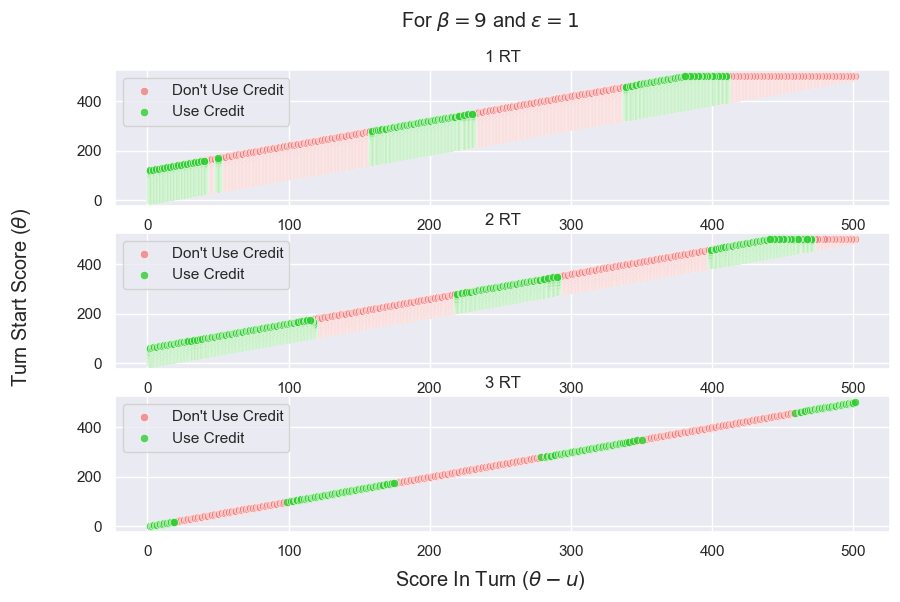

In [28]:
figure, ax = plt.subplots(3, 1,figsize=(10,6))

tokens = 9
epsilon = 1

for i in range (1,4):
    df_policy_check = df.loc[(df.tokens==tokens) & (df.epsilon==epsilon) & (df.remaining_throws==i)]
    df_policy_check[['score','score_in_turn','policy_is_token']]

    fig = sns.scatterplot(data=df_policy_check.loc[df_policy_check.policy_is_token==False], x="score_in_turn",y="score",alpha=0.8,label='Don\'t Use Credit',color='lightcoral',ax=ax[i-1])
    fig = sns.scatterplot(data=df_policy_check.loc[df_policy_check.policy_is_token==True], x="score_in_turn",y="score",alpha=0.8,label='Use Credit',color='limegreen',ax=ax[i-1])
    ax[i-1].set(xlabel="  ")
    ax[i-1].set(ylabel=None)
    ax[i-1].set(title=f"{i} RT")
    
figure.suptitle(rf'For $\beta={tokens}$ and $\epsilon={epsilon}$')
figure.supylabel(r'Turn Start Score ($\theta$)')
figure.supxlabel(r'Score In Turn ($\theta - u$)')
# plt.setp(ax, xlim=(0,100), ylim=(0,200))
# plt.xlim(0,100)
# plt.ylim(0,200)
#fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[2])

/Users/rachael/miniconda3/envs/darts/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/rachael/miniconda3/envs/darts/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


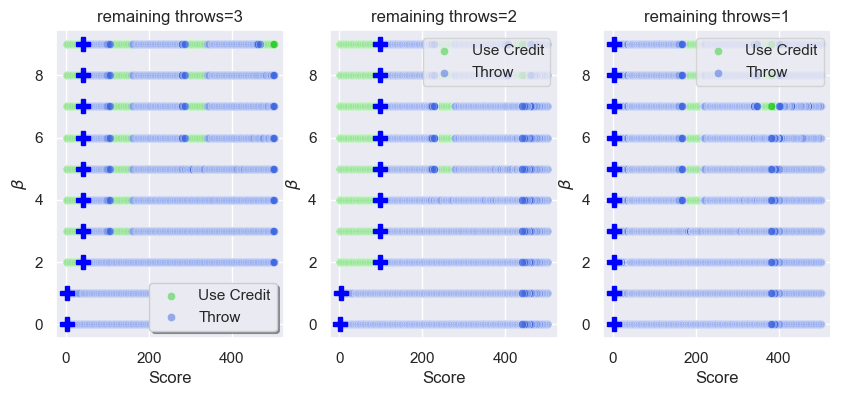

In [29]:
figure, ax = plt.subplots(1, 3,figsize=(10,4))

epsilon = 5
df_temp = df[df.optimal_policy != -1]

df_temp3 = df_temp[df_temp.remaining_throws==3]
df_actions3 = df_temp3[df_temp3.epsilon == epsilon]
#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[0])
fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[0])

fig = ax[0].set_ylabel(r'$\beta$')
fig = ax[0].set_xlabel(r'Score')
fig = ax[0].set_title(rf'remaining throws={3}')
fig = ax[0].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==True)].score.max()
    min_throw = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==False)].score.min()
    # ax[0].plot(max_token,t,marker='X',markersize=10,color='green')
    ax[0].plot(min_throw,t,marker='P',markersize=10,color='blue')


df_temp2 = df_temp[df_temp.remaining_throws==2]
df_actions2 = df_temp2[df_temp2.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[1])
fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[1])

fig = ax[1].set_ylabel(r'$\beta$')
fig = ax[1].set_xlabel(r'Score')
fig = ax[1].set_title(rf'remaining throws={2}')
#fig = ax[1].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==True)].score_in_turn.max()
    min_throw = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==False)].score_in_turn.min()
    #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
    ax[1].plot(min_throw,t,marker='P',markersize=10,color='blue')


df_temp1 = df_temp[df_temp.remaining_throws==1]
df_actions1 = df_temp1[df_temp1.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[2])
fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[2])

fig = ax[2].set_ylabel(r'$\beta$')
fig = ax[2].set_xlabel(r'Score')
fig = ax[2].set_title(rf'remaining throws={1}')
#fig = ax[2].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==True)].score_in_turn.max()
    min_throw = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==False)].score_in_turn.min()
    #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
    ax[2].plot(min_throw,t,marker='P',markersize=10,color='blue')


#fig = figure.suptitle(r'Optimal Use of Credits in Different States')

